In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Manipulação de valor de pixel

Vamos ler uma imagem em tons de cinza:

In [3]:
img = cv2.imread('Unequalized_Hawkes_Bay_NZ.jpg')  

In [4]:
img.shape

(683, 1024, 3)

Note que a imagem tem os tres canais de cor (B, G, R)

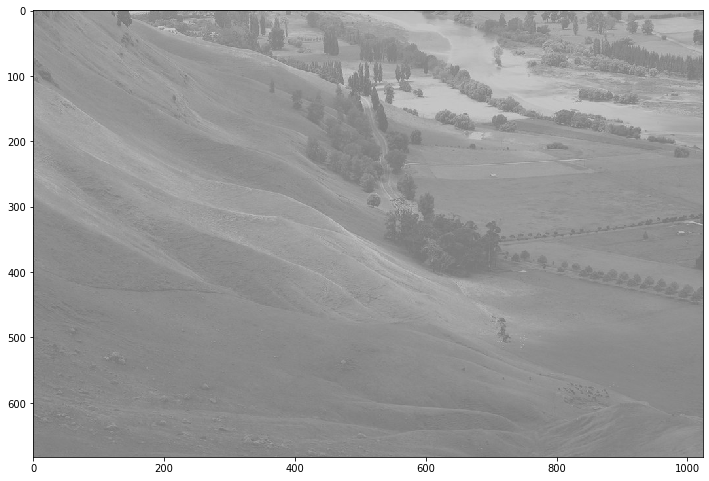

In [5]:
plt.figure(figsize=(12,12))
plt.imshow(img[:,:,::-1], cmap='gray')

Convertendo a imagem colorida para monocromática:

In [6]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [7]:
img.shape

(683, 1024)

In [8]:
type(img)

numpy.ndarray

In [9]:
img.dtype

dtype('uint8')

Vamos usar o matplotlib para mostrar a imagem em tons de cinza:

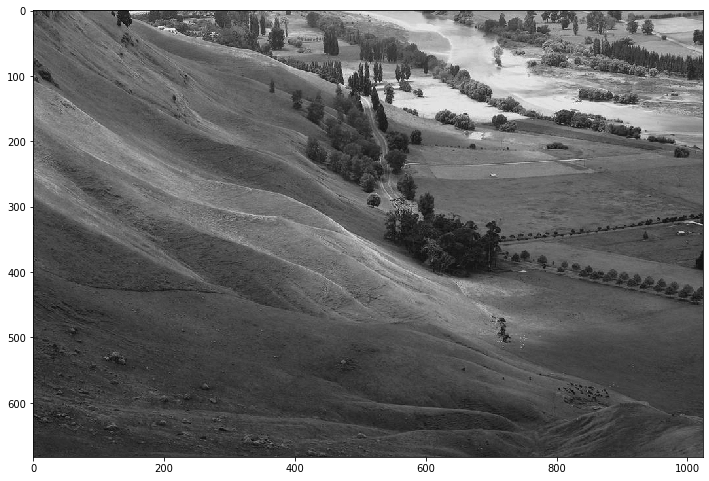

In [10]:
plt.figure(figsize=(12,12))
plt.imshow(img, cmap='gray')

Observe que o matplotlib automaticamente muda as tonalidades de cinza de modo que a escala disponível (do preto ao branco) seja utilizada. Para ter uma idéia mais realista da imagem, use os argumentos vmin e vmax

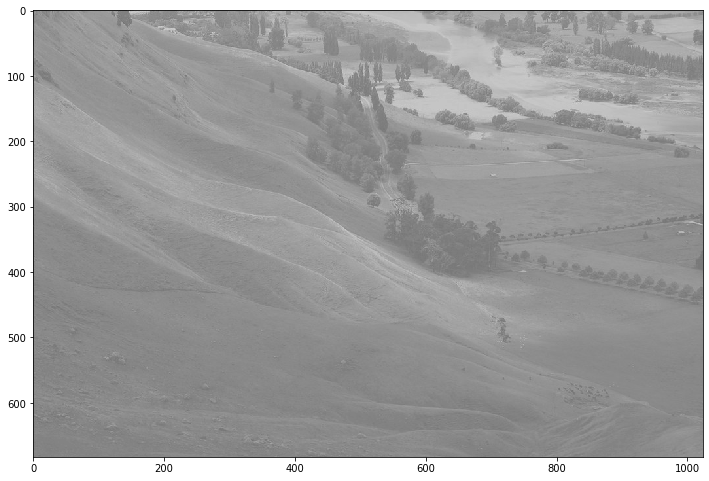

In [11]:
plt.figure(figsize=(12,12))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

Para facilitar a exibição de imagens vou fazer uma função que automaticamente organiza uma lista de imagens dadas em uma estrutura de subplots:

In [12]:
WIDTH = 6
HEIGHT = 4
NCOLS = 2

def show_images(imgs, width=WIDTH, height=HEIGHT, ncols=NCOLS):
    nrows = (len(imgs) + 1) // ncols
    
    plt.figure(figsize=(ncols*width, nrows*height))
    for idx, img in enumerate(imgs):
        plt.subplot(nrows, ncols, idx+1)
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        plt.axis('off')
    plt.show()

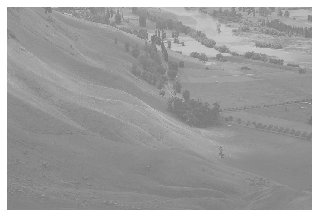

In [13]:
show_images([img])

# Histograma

Com OpenCV:

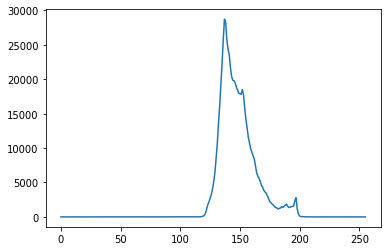

In [14]:
hist = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(hist)

Com Numpy:

In [15]:
hist, bins = np.histogram(img.ravel(), bins=256, range=[0, 256])
print(bins.shape)
print(hist.shape)

(257,)
(256,)


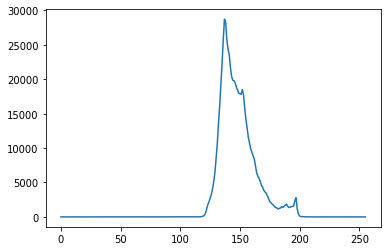

In [16]:
plt.plot(bins[:-1], hist)

O *dynamic range* de uma imagem é a faixa de valores efetivamente usada pelos seus pixels:

In [17]:
low = img.min()
high = img.max()
low, high

(114, 208)

**Atividade**: Explique o que o *dynamic range* desta imagem tem a ver com seu contraste.

# Brilho e contraste

**Atividade**: Implemente brilho e contraste. Não se preocupe com desempenho, apenas implemente matematicamente as operações. Dica: ``np.clip()``, ``np.uint8()`` e ``np.float()`` podem ajudar.

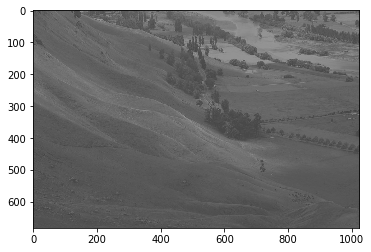

In [47]:
def muda_brilho(img,n):
    resultado = img + n
    return np.clip(resultado,0,255)

plt.imshow(muda_brilho(img,-50), cmap='gray', vmin=0, vmax=255)

In [ ]:
def muda_contrate(img,fator):
    media = np.mean(img)
    return np.clip(fator*(img-media)+media)

**Atividade**: Implemente a operação de aumento máximo do *dynamic range*.

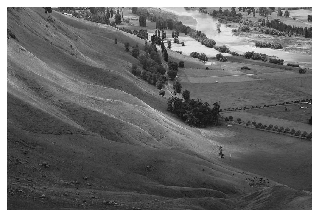

In [53]:
def dinamic(img):
    vmin = np.min(img)
    vmax = np.max(img)
    img -= vmin
    img = img/(vmax-vmin)
    img = 255*img
    return img

show_images([dinamic(img)])

**Atividade**: Analise o histograma da imagem recalculada. O que aconteceu com o *dynamic range*?

In [55]:
#hist = cv2.calcHist([dinamic(img)],[0],None,[256],[0,256])
#plt.plot(hist)

error: OpenCV(4.1.0) /io/opencv/modules/imgproc/src/histogram.cpp:919: error: (-210:Unsupported format or combination of formats)  in function 'calcHist'


# Equalização de histograma

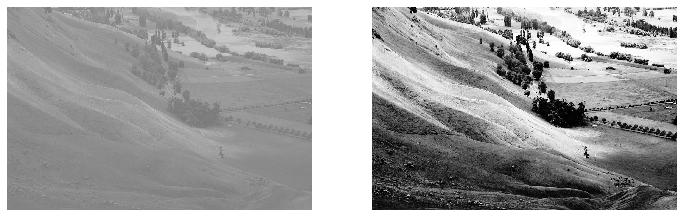

In [18]:
img_eq = cv2.equalizeHist(img)
show_images([img, img_eq])

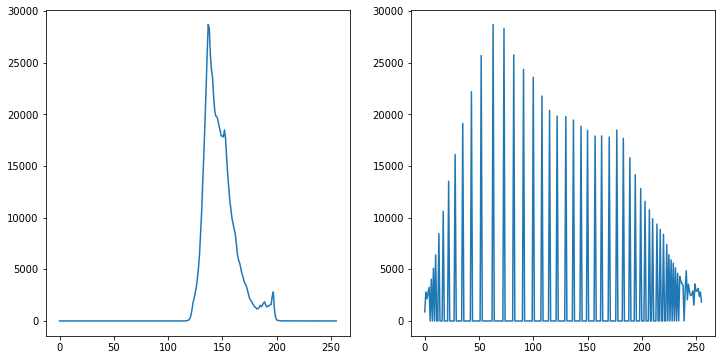

In [19]:
hist = cv2.calcHist([img],[0],None,[256],[0,256])
hist_eq = cv2.calcHist([img_eq],[0],None,[256],[0,256])

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(hist)
plt.subplot(122)
plt.plot(hist_eq)
plt.show()

Parece boa esta idéia de remapear os valores de pixel para preencher uniformemente o intervalo de níveis de cinza. Mas temos um problema: algumas áreas ficaram saturadas!

**Atividade**: Você saberia explicar por que isso acontece?

Uma solução para este problema é a técnica CLAHE (Contrast-Limited Adaptive Histogram Equalization), que faz uma equalização "local" de histograma para cada ponto da imagem, veja o resultado:

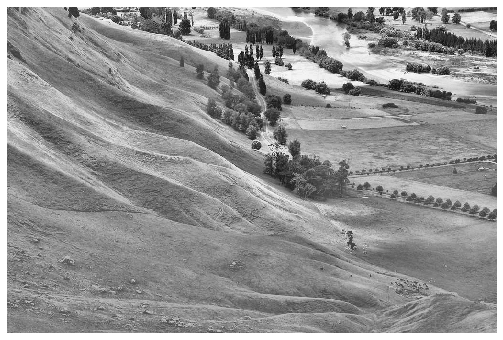

In [20]:
clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(10,10))
img_clahe = clahe.apply(img)
show_images([img_clahe], width=12, height=6)

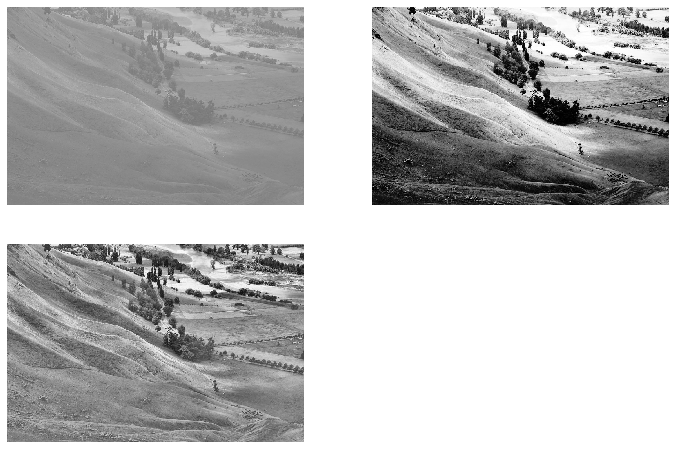

In [21]:
show_images([img, img_eq, img_clahe])

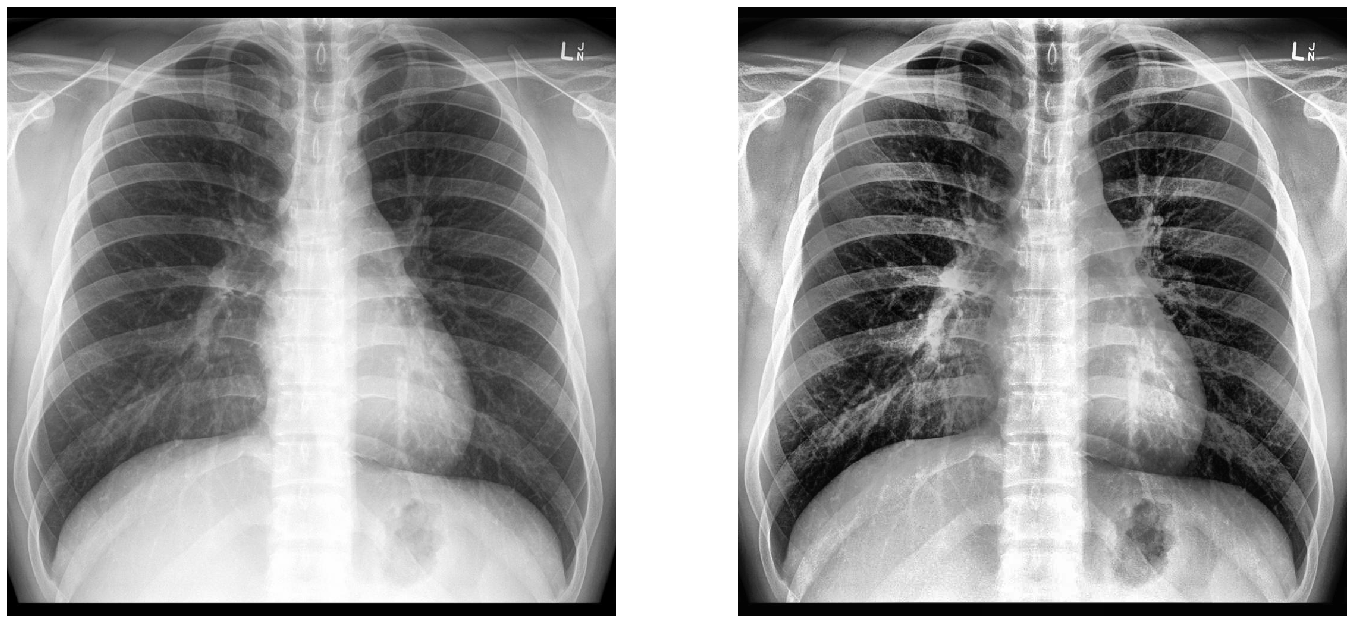

In [22]:
img_xray = cv2.imread('xray.jpg')
img_xray = cv2.cvtColor(img_xray, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(5,5))
img_xray_clahe = clahe.apply(img_xray)
show_images([img_xray, img_xray_clahe], width=12, height=12)

No artigo "Contrast-Limited Adaptive Histogram Equalization: Speed and Effectiveness" tem uma descrição do algoritmo. Tem também uma descrição de uma implementação "raiz" de uma placa de circuito digital para cálculo do CLAHE! Assim eram os engenheiros de computação do passado, galera!

# Ruído em imagens

Vamos construir uma imagem de teste bem simples:

In [23]:
img_test = np.zeros([256, 256], dtype=np.uint8)
img_test[:,:] = 120
img_test[40:120, 50:170] = 150
img_test[160:230, 40:220] = 80

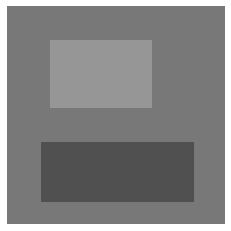

In [24]:
show_images([img_test])

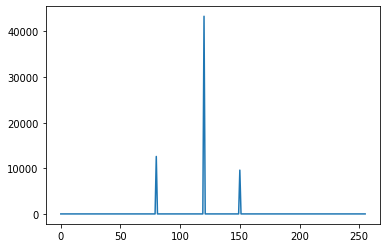

In [25]:
hist = cv2.calcHist([img_test],[0],None,[256],[0,256])
plt.plot(hist)

Agora vamos construir uma "imagem" feita de valores aleatórios, escolhidos segundo uma distribuição gaussiana:

In [26]:
img_noise = np.random.normal(loc=0.0, scale=5.0, size=img_test.shape)

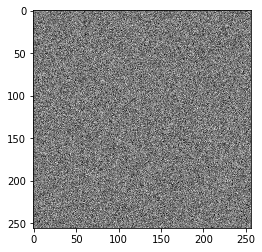

In [27]:
plt.imshow(img_noise, cmap='gray')

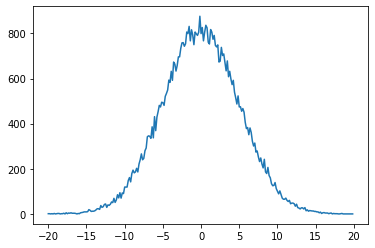

In [28]:
hist, bins = np.histogram(img_noise.ravel(), bins=256, range=[-20.0, 20.0])
plt.plot(bins[:-1], hist)

Parece gaussiano! Vamos somar esse "ruido" à nossa imagem limpa:

In [29]:
img_test_noise = np.clip(img_test + img_noise, 0, 255).astype('uint8')

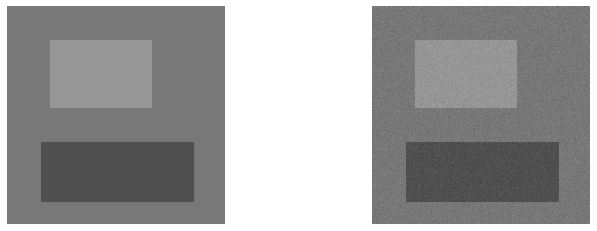

In [30]:
show_images([img_test, img_test_noise])

**Atividade**: **ANTES DE RODAR A CÉLULA SEGUINTE, ESBOCE O HISTOGRAMA DA IMAGEM RUIDOSA!**

Pronto, agora pode rodar a célula de cálculo do histograma. Você conseguiu acertar?

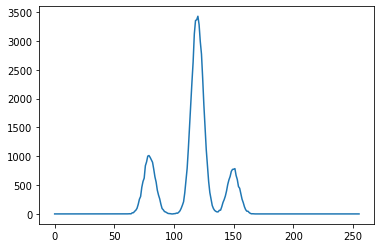

In [31]:
hist = cv2.calcHist([img_test_noise],[0],None,[256],[0,256])
plt.plot(hist)

# Segmentando imagens por limiar

Apesar do ruído, a imagem ruidosa ainda apresenta uma boa distinção entre os retângulos. Podemos separar o retangulo escuro simplesmente indicando um nível de limiar tal que os pixels do retangulo estejam abaixo do limiar, e os demais estejam acima:

In [32]:
mask_dark_square = img_test_noise < 100
img_dark_square = 255 * mask_dark_square

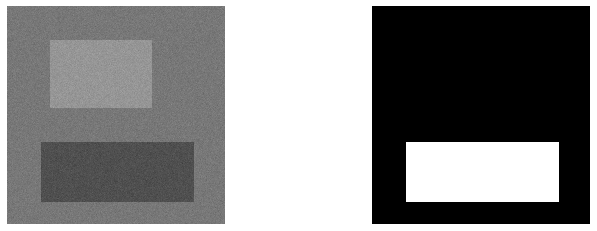

In [33]:
show_images([img_test_noise, img_dark_square])

Usando o OpenCV podemos também executar a segmentação por limiar:

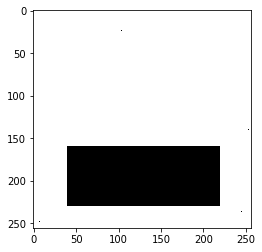

In [34]:
limiar, img_dark_square_inverted = cv2.threshold(img_test_noise, 100, 255, cv2.THRESH_BINARY)
plt.imshow(img_dark_square_inverted, cmap='gray', vmin=0, vmax=255)

In [35]:
limiar

100.0

**Atividade**: Modifique o código acima para que a imagem não saia invertida - verifique a documentação do ``cv2.threshold()``.

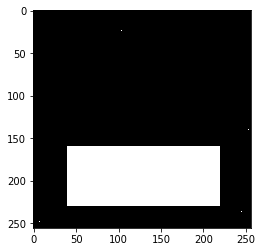

In [59]:
limiar, img_dark_square_inverted = cv2.threshold(img_test_noise, 100, 255, cv2.THRESH_BINARY_INV)
plt.imshow(img_dark_square_inverted, cmap='gray', vmin=0, vmax=255)

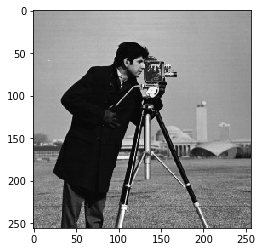

In [36]:
img_cameraman = cv2.cvtColor(cv2.imread('cameraman.jpg'), cv2.COLOR_BGR2GRAY)
plt.imshow(img_cameraman, cmap='gray', vmin=0, vmax=255)

**Atividade**: Tente segmentar o casaco do cameraman. Não vai ficar perfeito, mas é um começo!

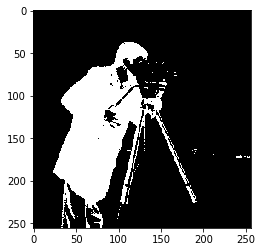

In [75]:
limiar, img_coat = cv2.threshold(img_cameraman, 24, 255, cv2.THRESH_BINARY_INV)
plt.imshow(img_coat, cmap='gray', vmin=0, vmax=255)

Ao invés de selecionar manualmente o nível de separação entre categorias, existem algoritmos para fazer a seleção do limiar. Dentre estes um dos mais famosos é o algoritmo de Otsu.

In [76]:
limiar_otsu, img_coat_otsu = cv2.threshold(img_cameraman, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

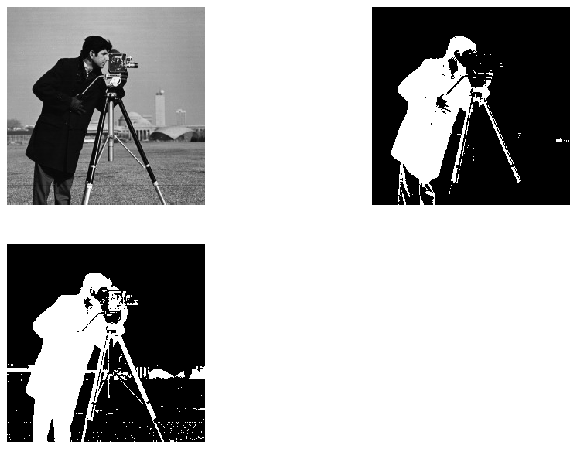

In [77]:
show_images([img_cameraman, img_coat, img_coat_otsu])

In [78]:
limiar_otsu

88.0

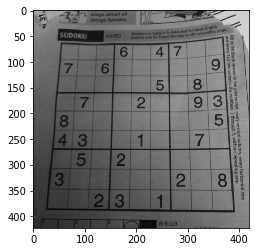

In [79]:
img_sudoku = cv2.cvtColor(cv2.imread('sudoku-original.jpg'), cv2.COLOR_BGR2GRAY)
plt.imshow(img_sudoku, cmap='gray', vmin=0, vmax=255)

Vamos separar as linhas escuras do pano de fundo.

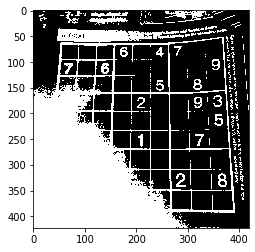

In [80]:
limiar_sudoku_otsu, img_sudoku_otsu = cv2.threshold(img_sudoku, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(img_sudoku_otsu, cmap='gray', vmin=0, vmax=255)

Opa, parece que não deu certo! O problema é que a imagem tem regiões claras e regiões escuras: um limiar único para a imagem toda não funciona!

Assim como no caso da "equalização de histograma" versus CLAHE, será que podemos fazer um "Otsu local"? Sim! Existe o threshold adaptativo!

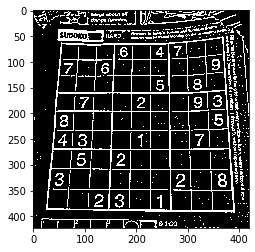

In [81]:
img_sudoku_adaptativo = cv2.adaptiveThreshold(img_sudoku, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 5)
plt.imshow(img_sudoku_adaptativo, cmap='gray', vmin=0, vmax=255)